# Intensity Interferometry

Consider a pair of detectors, $a$ and $b$, measuring the intensity of a common (extended) source of light. The time correlation of both signals provides information on the spatial distribution of the source.

$$\left<I_a(t)I_b(t)\right>_{\tau}=\frac{1}{\tau}\int_t^{t+\tau}\mathrm{d}t'I_a(t')I_b(t'),$$

where $\tau$ is the integration time of the correlator.

Denoting $\mathbf{r}$ the baseline--the relative distance between a pair of detectors--the intensity correlation can be written:

$$\left<I_a(t)I_b(t)\right>_{\tau}(\mathbf{r}) = \left<I_a\right>\left<I_b\right>(1+\left|\gamma_{12}(\mathbf{r})\right|^2),$$

where $\gamma_{12}(\textbf{r})$ is directly related to the Fourier transform of the source density distribution.

Here, we investigate the signal measured observed for an elliptic source, using a pair of telescope with an arbitrary baseline.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import importlib
import II
from II import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm

In [3]:
ls = II.LightSource(shape='ellipse')
uv = II.UVplane(ls)

[-30958.87416616  30958.87416616 -30958.87416616  30958.87416616]


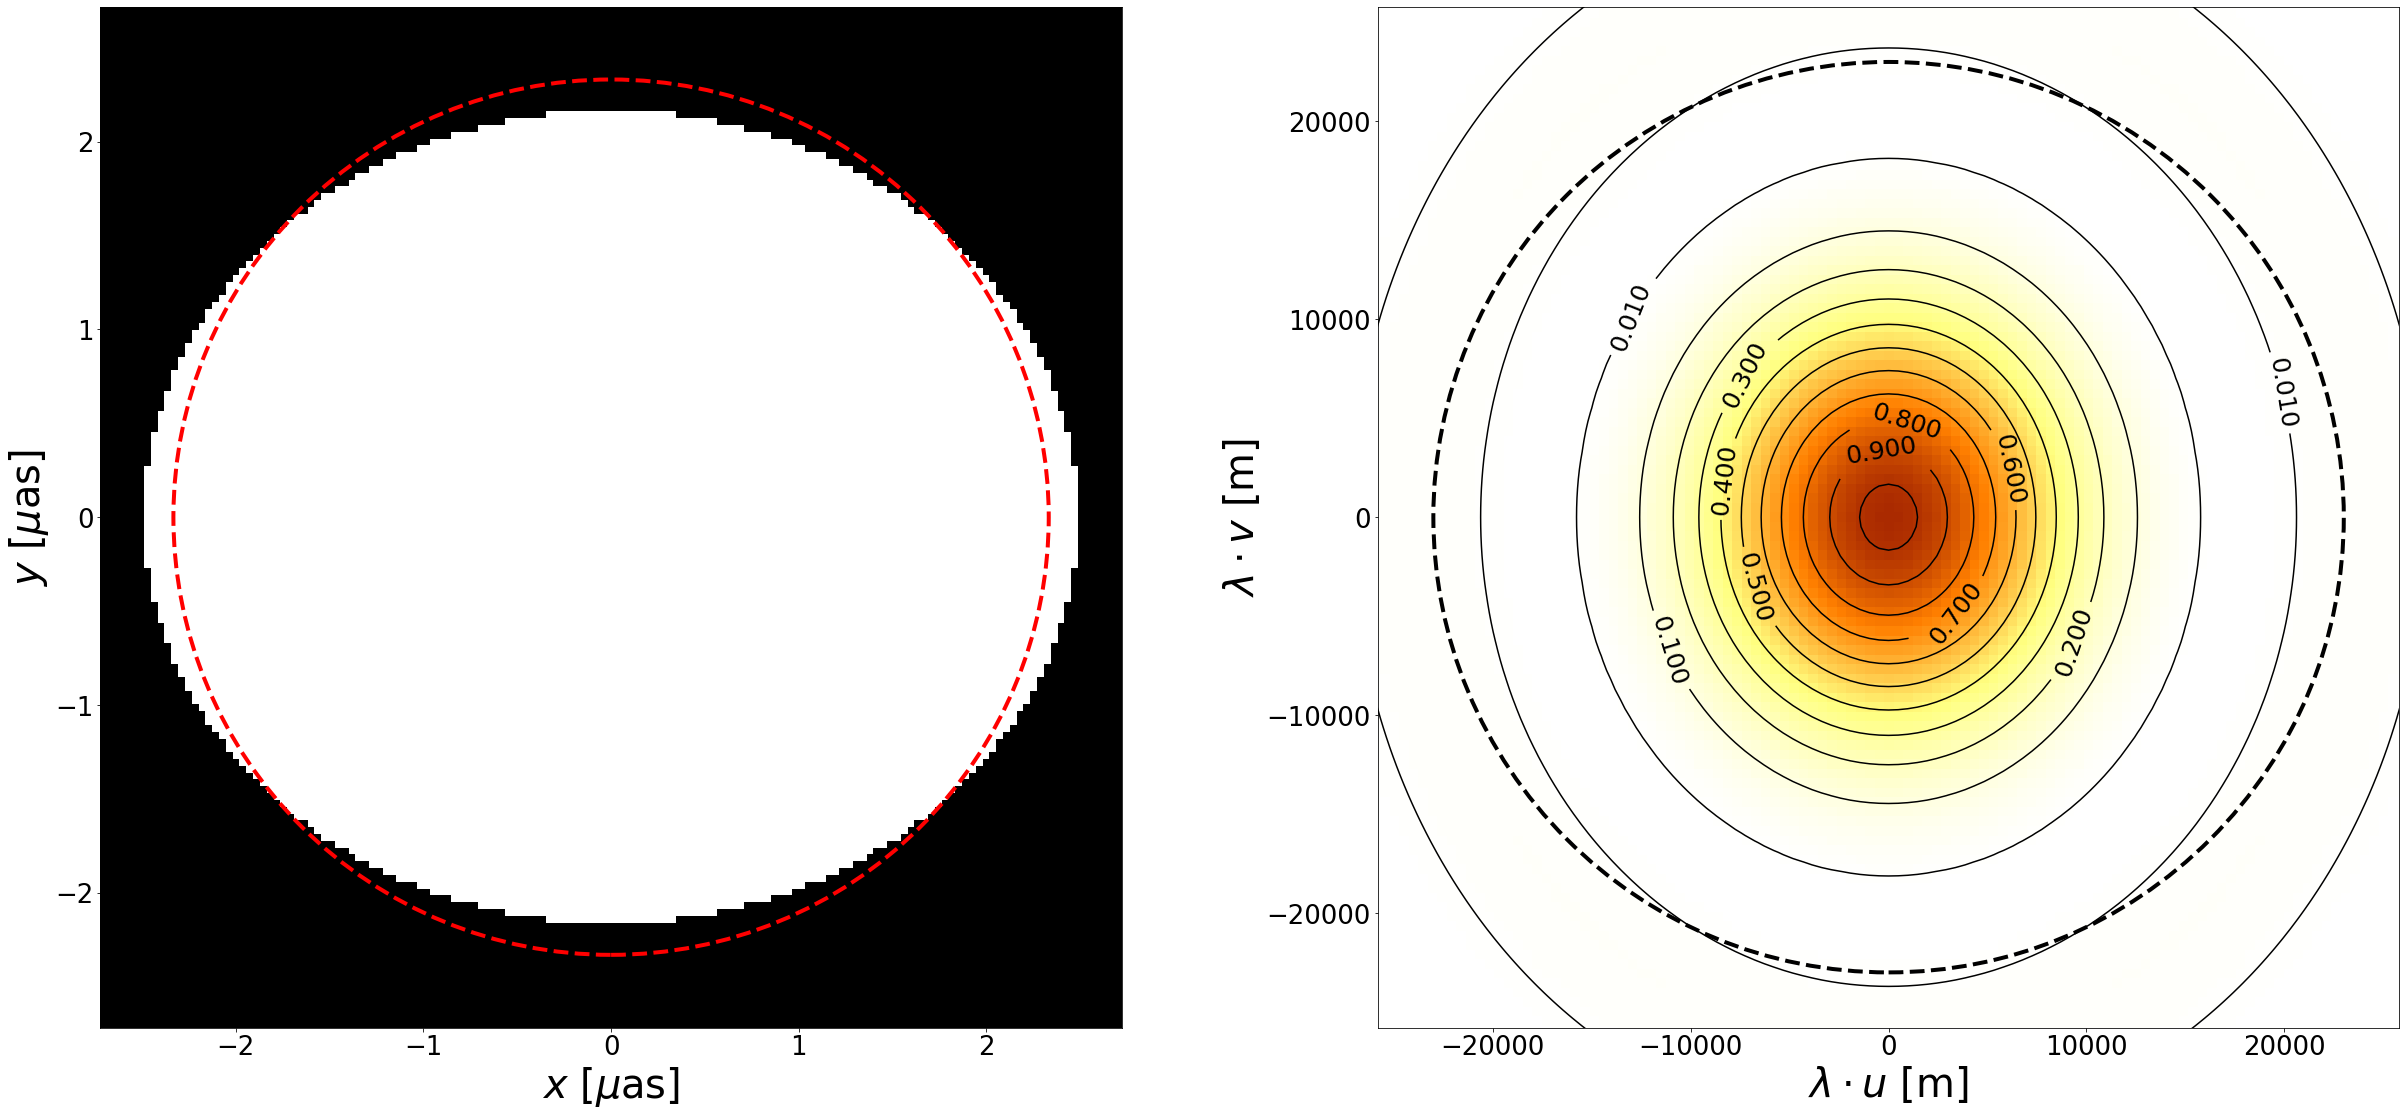

In [4]:
uv.plotFigure2()
#plt.savefig('poster.pdf', transparent=True)

In [5]:
cta = II.CTA(uv, bAddCTA=True, bAddELT=False, bAddVLT=False, nGrid=128, nPerTraj=1024)

3
0 0 04m_telescope.csv 04m_telescope.csv
0 1 12m_telescope.csv 04m_telescope.csv
1 1 12m_telescope.csv 12m_telescope.csv
0 2 23m_telescope.csv 04m_telescope.csv
1 2 23m_telescope.csv 12m_telescope.csv
2 2 23m_telescope.csv 23m_telescope.csv


In [6]:
cta.setGrids()

Computing SNR grid:


Pairs (23-23): 100%|██████████| 5/5 [00:00<00:00,  9.09it/s]
/net/cephfs/home/hlasco/apt19/II.py:373: RuntimeWarning: invalid value encountered in true_divide
  areaGrid = np.where(nInGrid == 0, 0, areaGrid / nInGrid)


9600


In [ ]:
snr  = cta.getSNRGrid()
time = cta.getTimeGrid()
area = cta.getAreaGrid()

In [ ]:
x = np.linspace(-cta.bline_max, cta.bline_max, cta.N_snr_grid)
y = np.linspace(-cta.bline_max, cta.bline_max, cta.N_snr_grid)
xx, yy = np.meshgrid(x, y)
plt.figure(figsize=(10, 8))
plt.pcolormesh(xx ,yy , time.T, cmap='viridis', norm=LogNorm())
plt.colorbar()
print(np.sum(time)/32)

In [ ]:
print(np.mean(area[area>0]))
print(np.mean(area))

In [ ]:
x = np.linspace(-cta.bline_max, cta.bline_max, cta.N_snr_grid)
y = np.linspace(-cta.bline_max, cta.bline_max, cta.N_snr_grid)
xx, yy = np.meshgrid(x, y)
plt.figure(figsize=(8, 8))
plt.pcolormesh(xx ,yy , snr.T, norm=LogNorm())
plt.colorbar()

In [ ]:
nNights = 1
signal1 = cta.getSignal(nNights = nNights, phi_source = 0, bNoise=True)
plt.figure(figsize=(8, 8))
plt.pcolormesh(xx ,yy ,(signal1.T), norm=LogNorm())#, vmin=2.6e-4, vmax=3.2e-4)
plt.colorbar()

In [535]:
print(np.mean(signal1[signal1>0]))
print(np.min(signal1[signal1>0]))
print(np.max(signal1[signal1>0]))

4.692351690160865e-06
5.034276643542189e-08
0.0007744078497858817


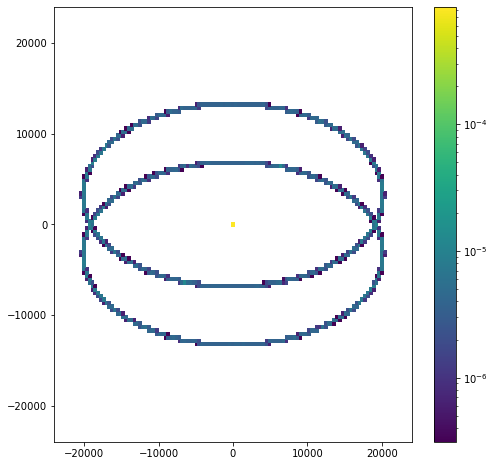

In [536]:
signal1 = cta.getSignal(nNights = 1, phi_source = np.pi/4, bNoise=False)
plt.figure(figsize=(8, 8))
plt.pcolormesh(xx ,yy ,signal1.T, norm=LogNorm())#, vmin=2.6e-4, vmax=3.2e-4)
plt.colorbar()

99066024.99576223 2.163785603304249e-11


<ipython-input-537-2ad7baa86fd8>:9: RuntimeWarning: invalid value encountered in true_divide
  sigma = signal2 / (snr * np.sqrt(nNights))
<ipython-input-537-2ad7baa86fd8>:10: RuntimeWarning: invalid value encountered in true_divide
  data = s/sigma


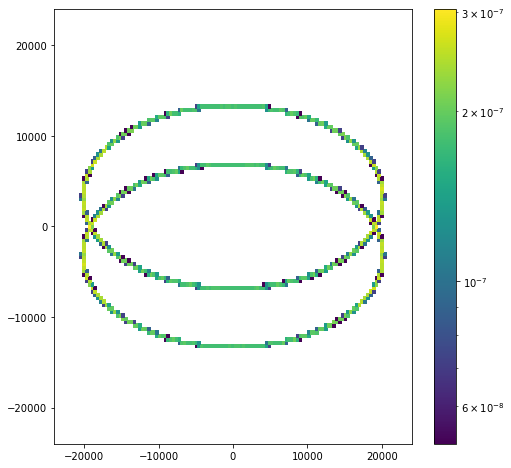

In [537]:
nNights=100
#print(.05*180/np.pi)
signal1 = cta.getSignal(nNights=nNights, phi_source = 0.5, bNoise=False)
signal2 = cta.getSignal(nNights=nNights, phi_source = 0., bNoise=True)

signal1[np.where(signal1 == signal1.max())] = 0
signal2[np.where(signal2 == signal2.max())] = 0
s = (signal1 - signal2)
sigma = signal2 / (snr * np.sqrt(nNights))
data = s/sigma
mask = (data*1 == data)
print(np.sum(data[mask]**2), np.sum(sigma[mask]**2))
plt.figure(figsize=(8, 8))
plt.pcolormesh(xx ,yy ,np.fabs(sigma.T), norm=LogNorm())
plt.colorbar()

In [538]:
import emcee

def log_likelihood(phi, signal, snr, i_night):
    model = cta.getSignal(nNights = i_nights, phi_source = phi, bNoise=False)
    mask = (snr * np.sqrt(i_nights) > 1e-10 )
    
    std = model[mask] / (snr[mask] * np.sqrt(i_nights))
    obs = signal[mask]
    exp = model[mask]
    
    ret =  -.5*np.sum((obs - exp)**2 / std**2 + np.log(2*np.pi*std**2))
    print(phi, ret,np.mean(std))
    return ret

def log_prior(phi): #prior for rp is flat around rp_true with + and - 20x error on rp_true
    phi_range = -np.pi/4 < phi < np.pi/4
    if phi_range:
        return 0.0
    return -np.inf

def log_probability(phi, signal, snr, i_night):
    lp = log_prior(phi)
    return lp + log_likelihood(phi, signal, snr, i_night)

def run_mcmc(i_night, phi_source, n_walkers=4, steps=1000):
    pos = np.array([[np.random.uniform(-np.pi/4, np.pi/4)] for k in range(n_walkers)])
    nwalkers, ndim = pos.shape
    signal = cta.getSignal(nNights = i_nights, phi_source = phi_source, bNoise=True)
    snr = cta.getSNRGrid()
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(signal, snr, i_night))
    sampler.run_mcmc(pos, steps, progress=True)

    return sampler

In [539]:
sampler_1 = run_mcmc(i_night=1, phi_source = 0.0, n_walkers=2, steps=100)
#sampler_10 = run_mcmc(i_night=10, phi_source = 0.0, n_walkers=2, steps=500)
#sampler_100 = run_mcmc(i_night=100, phi_source = 0.0, n_walkers=2, steps=500)
#sampler_10000 = run_mcmc(i_night=10000, phi_source = 0.0, n_walkers=2, steps=50)

labels = ["phi_source"]
truths = [phi_source]

 
flat_samples_1 = sampler_1.get_chain(discard=0, thin=1, flat=True)
#flat_samples_10 = sampler_10.get_chain(discard=0, thin=1, flat=True)
#flat_samples_100 = sampler_100.get_chain(discard=0, thin=1, flat=True)
#flat_samples_10000 = sampler_10000.get_chain(discard=0, thin=1, flat=True)


[0.66587262] -23285852520.101517 1.419267462320391e-07


  0%|          | 0/100 [00:00<?, ?it/s]

[0.5619145] -3803565769.8250265 1.4194504520228052e-07
[0.62043397] -1052753740.4289812 1.421113977055912e-07


  1%|          | 1/100 [00:01<02:51,  1.73s/it]

[0.56876636] -2613735239.1568365 1.4196028104977824e-07
[0.54385106] -479112862237.42084 1.4225915229675143e-07


  2%|▏         | 2/100 [00:03<02:45,  1.69s/it]

[0.64182698] -20966630593.673172 1.4201011354440224e-07
[0.6025888] -563269320590.2163 1.419662836009048e-07


  3%|▎         | 3/100 [00:05<02:46,  1.71s/it]

[0.54581838] -171559727847.7148 1.4239480034372707e-07
[0.52029157] -5254178067051.323 1.4191131957828347e-07


  4%|▍         | 4/100 [00:06<02:44,  1.71s/it]

[0.60162217] -2977355172.9660525 1.4180369019921315e-07
[0.63725253] -66039216290.63308 1.4146986444230654e-07


  5%|▌         | 5/100 [00:08<02:41,  1.70s/it]

[0.58425824] -17450424949.688988 1.4193425945438375e-07
[0.62346958] -5308086228397.862 1.4204814182705e-07


  6%|▌         | 6/100 [00:10<02:41,  1.72s/it]

[0.59291683] -5722266760223790.0 1.4189468841314765e-07
[0.55308167] -23901488967958.316 1.4185616142771654e-07


  7%|▋         | 7/100 [00:11<02:40,  1.73s/it]

[0.63895825] -4443314057131.301 1.4157189520061614e-07
[0.52913643] -64177114954.71187 1.4156829387770758e-07


  8%|▊         | 8/100 [00:13<02:38,  1.72s/it]

[0.64777489] -227185371.949009 1.4259191912190973e-07
[0.52908074] -106523608927.64844 1.4157081097397499e-07


  9%|▉         | 9/100 [00:15<02:32,  1.67s/it]

[0.69538432] -5386903159841.509 1.4205496150879657e-07
[0.53972831] -36339009289.0891 1.419299197241677e-07


 10%|█         | 10/100 [00:17<02:43,  1.82s/it]

[0.71089668] -449555824580.7169 1.4134134400817604e-07
[0.60972022] -146211579729.346 1.424388570687899e-07


 11%|█         | 11/100 [00:19<02:42,  1.83s/it]

[0.55845839] -7496313062397.759 1.4170388680048626e-07


Traceback (most recent call last):
  File "/home/cluster/hlasco/bulk1/miniconda3/envs/pyenv/lib/python3.8/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-538-7e9869fb9aa0>", line 23, in log_probability
    return lp + log_likelihood(phi, signal, snr, i_night)
  File "<ipython-input-538-7e9869fb9aa0>", line 4, in log_likelihood
    model = cta.getSignal(nNights = i_nights, phi_source = phi, bNoise=False)
  File "/net/cephfs/home/hlasco/apt19/II.py", line 417, in getSignal
    mean = self.timeGrid[i,j] * self.areaGrid[i,j]**2 * fac_signal * self.spline(u, v)
  File "/home/cluster/hlasco/bulk1/miniconda3/envs/pyenv/lib/python3.8/site-packages/scipy/interpolate/interpolate.py", line 277, in __call__
    y = np.sort(y)
  File "<__array_function__ internals>", line 5, in sort
  File "/home/cluster/hlasco/bulk1/miniconda3/envs/pyenv/lib/python3.8/site-packages/numpy/core/fromnumeric.py", line 990, in sort
    a = a

emcee: Exception while calling your likelihood function:
  params: [0.72476656]
  args: (array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 1)
  kwargs: {}
  exception:


KeyboardInterrupt: 

In [445]:
print("MCMC results:")
mcmc = np.percentile(flat_samples_1[:], [16, 50, 84]) #takes 16%, 50% and 84% (mu-MinusError, mu and mu+PlusError)
q = np.diff(mcmc) #calculates MinusError and PlusError
print('1 night', labels[0],"={0:.5f} -{1:.5f} +{2:.5f}".format(mcmc[1], q[0], q[1]))

mcmc = np.percentile(flat_samples_10[:], [16, 50, 84]) #takes 16%, 50% and 84% (mu-MinusError, mu and mu+PlusError)
q = np.diff(mcmc) #calculates MinusError and PlusError
print('10 night', labels[0],"={0:.5f} -{1:.5f} +{2:.5f}".format(mcmc[1], q[0], q[1]))

mcmc = np.percentile(flat_samples_100[:], [16, 50, 84]) #takes 16%, 50% and 84% (mu-MinusError, mu and mu+PlusError)
q = np.diff(mcmc) #calculates MinusError and PlusError
print('100 night', labels[0],"={0:.5f} -{1:.5f} +{2:.5f}".format(mcmc[1], q[0], q[1]))

mcmc = np.percentile(flat_samples_1000[:], [16, 50, 84]) #takes 16%, 50% and 84% (mu-MinusError, mu and mu+PlusError)
q = np.diff(mcmc) #calculates MinusError and PlusError
print('1000 night', labels[0],"={0:.5f} -{1:.5f} +{2:.5f}".format(mcmc[1], q[0], q[1]))

MCMC results:
1 night phi_source =0.28923 -0.78706 +0.34653
10 night phi_source =-0.13679 -0.51708 +0.69979
100 night phi_source =-0.04050 -0.56234 +0.64460
1000 night phi_source =-0.02292 -0.01329 +0.01877


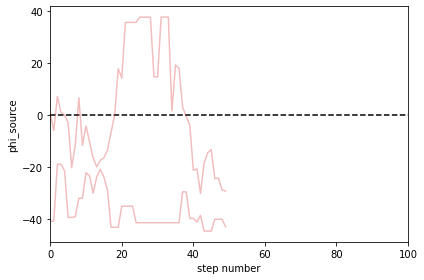

In [461]:
plt.axhline(truths[0], color='k', linestyle='--')
plt.plot(sampler_1.get_chain()[:,:,i]*180/np.pi, alpha=0.3, color='C0')
#plt.plot(sampler_10.get_chain()[:,:,i]*180/np.pi, alpha=0.3, color='C1')
#plt.plot(sampler_100.get_chain()[:,:,i]*180/np.pi, alpha=0.3, color='C2')
#plt.plot(sampler_10000.get_chain()[:,:,i]*180/np.pi, alpha=0.3, color='C3')

plt.xlim(0, len(samples))
plt.ylabel(labels[0])
plt.xlabel("step number")
#plt.savefig('TotalChain.pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

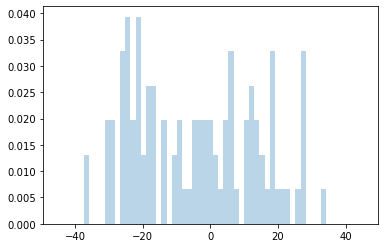

In [454]:
bins = np.linspace(-np.pi/4*180/np.pi, np.pi/4*180/np.pi, 60)
#h1 = plt.hist(flat_samples_1*180/np.pi, bins=bins, density=True, alpha=.3)
#h2 = plt.hist(flat_samples_10*180/np.pi, bins=bins, density=True, alpha=.3)
#h3 = plt.hist(flat_samples_100*180/np.pi, bins=bins, density=True, alpha=.3)
h3 = plt.hist(flat_samples_10000*180/np.pi, bins=bins, density=True, alpha=.3)

0 7
-0.39269908169872414 1.05584659492013e-16965642
-0.367363657073 2.62048134008241e-481301
-0.34202823244727587 8.03290348512158e-631355
-0.31669280782155174 6.53607389380568e-62061649
-0.2913573831958276 1.76464528519383e-11478532
-0.26602195857010347 4.62557190190196e-398055508
-0.2406865339443793 4.02709734781750e-5017530525
-0.21535110931865517 7.01332551469913e-1087200
-0.19001568469293104 2.30122790091751e-21592948555
-0.1646802600672069 4.51187435336777e-349112534
-0.13934483544148274 6.51761653254523e-1892312463
-0.1140094108157586 1.77414269729459e-605006875
-0.08867398619003447 1.46080567660793e-28269696999
-0.06333856156431034 3.65319778031470e-1000247
-0.0380031369385862 6.82979771209576e-763546
-0.012667712312862067 7.30227644996361e-25927
0.012667712312862067 4.39529407628343e-25283
0.0380031369385862 4.43290045736720e-192729
0.06333856156431034 1.53207825236493e-3826957
0.08867398619003447 2.21965150005400e-12851645289
0.11400941081575866 1.51432399907635e-8677455030
0

KeyboardInterrupt: 

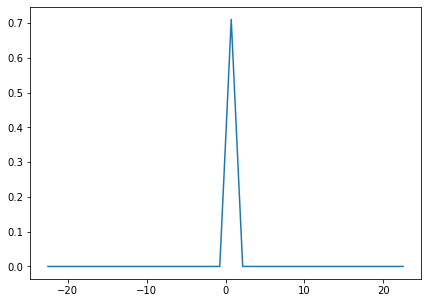

In [516]:
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
from matplotlib.lines import Line2D
# sympy allows symbolic calculations, so an arbitrary float precision.
# That's the only way I found to deal with the crazy numbers in the 
# likelihood function before normalization. Im pretty sure there exists
# way more elegant methods. Feel free to make it cleaner !!
import sympy as sp

snr = cta.getSNRGrid()
mask = snr < 0

fig = plt.figure(constrained_layout=False, figsize=(7,5))
N_phi    = 32
phi_range = np.pi / 8
phis = np.linspace(-phi_range, phi_range, N_phi)
dphi = 2 * phi_range / N_phi

nights = [7,30,90,180,365]
to_plot = nights
labels = ['24 Hours', '48 Hours ', '1 Week', '2 Weeks', '3 Months']
L = np.array([sp.zeros(N_phi, 1) for i in range(len(nights))])
idx = 0

for i, i_nights in enumerate(to_plot):
    signal = cta.getSignal(nNights = i_nights, phi_source = 0, bNoise=True)
    #signal[np.where(signal == signal.max())] = 0

    print(i, i_nights)
    for k, phi in enumerate(phis):
        model = cta.getSignal(nNights = i_nights, phi_source = phi, bNoise=False)
        #model[np.where(model == model.max())] = 0
        
        mask = (snr * i_nights**0.5 > 1e-5 )
        std = model[mask] / (snr[mask] * i_nights**0.5)
        obs = signal[mask]
        exp = model[mask]
        chi2 =  (obs - exp)**2 / std**2
        p = sp.exp(-0.5*np.sum(chi2))
        L[i][k] = p
        print(phi, p)
    norm = np.sum(L[i,:]) * dphi
    L[i,:] = L[i,:] / norm
    #if (4*i % N_nights == 0):
    if i_nights in to_plot:
        print(i, idx, labels[idx])
        plot = plt.plot((phis) * 180 / np.pi, L[i,:] * np.pi / 180, label=labels[idx])
        """
        upper_ax[idx].pcolormesh(xx ,yy ,signal, norm=LogNorm())#, vmin=2.7e-4, vmax=3.2e-4)
        upper_ax[idx].set_yticklabels([])
        upper_ax[idx].set_xticklabels([])
        upper_ax[idx].xaxis.set_ticks_position('none') 
        upper_ax[idx].yaxis.set_ticks_position('none') 
        line = [Line2D([0], [0], color=plot[0].get_color())]
        upper_ax[idx].legend(line, ['{} nights'.format(int(i_nights))],
                             loc='lower center', bbox_to_anchor=(0.5, -0.35))
        """
        idx = idx + 1
        
plt.legend()
        
plt.axvline(x=0, linestyle="--")
#ax5.set_xlim(-10, 10)
plt.xlabel('$\phi$ [deg]')
plt.ylabel('Likelihood')

#plt.savefig('likelihood_phi.pdf')

In [ ]:
fig = plt.figure(figsize=(12,10))
idx = 0
plt.axvline(x=0, linestyle="--", c='k')
labels = ['24 Hours', '48 Hours ', '1 Week', '2 Weeks', '...']
to_plot = nights
for i, i_nights in enumerate(to_plot):
    if i_nights in to_plot:
        x = (phis) * 180 / np.pi
        y = L[i,:] * np.pi / 180
        #y[np.fabs(x)>5]=0
        halfmax = np.max(y) / 2
        where = y > halfmax
        plot = plt.plot(x, y, label=labels[idx], lw=3)
        idx = idx + 1
    
    print(np.sum(L[i,:]))
    #np.savetxt("ELT_VLT_{}nights.txt".format(i_nights), np.c_[x, y], delimiter='\t')
plt.legend(fontsize=20)
plt.xlim(-20, 20)
#plt.ylim(0, 4)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.xlabel('$\phi$ [deg]',fontsize=25)
plt.ylabel('Likelihood',fontsize=25)
#plt.savefig('likelihood_plot_ELT_VLT.pdf', bbox_inches='tight')

In [5]:
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

def Gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

x, y = np.loadtxt('ELT_VLT_1nights.txt', delimiter='\t', unpack=True)
coeff, _ = curve_fit(Gauss, x, y, p0=[1.0, 0.0, 5], bounds=([0, -2, 0], [100, 2, 100]), maxfev=3000)
print(coeff[2])
x, y = np.loadtxt('ELT_VLT_2nights.txt', delimiter='\t', unpack=True)
coeff, _ = curve_fit(Gauss, x, y, p0=[1.0, 0.0, 5], bounds=([0, -2, 0], [100, 2, 100]), maxfev=3000)
print(coeff[2])
x, y = np.loadtxt('ELT_VLT_4nights.txt', delimiter='\t', unpack=True)
coeff, _ = curve_fit(Gauss, x, y, p0=[1.0, 0.0, 5], bounds=([0, -2, 0], [100, 2, 100]), maxfev=3000)
print(coeff[2])
x, y = np.loadtxt('ELT_VLT_7nights.txt', delimiter='\t', unpack=True)
coeff, _ = curve_fit(Gauss, x, y, p0=[1.0, 0.0, 5], bounds=([0, -2, 0], [100, 2, 100]), maxfev=3000)
print(coeff[2])

0.5557005439013499
0.39315761173813973
0.2779135649788534
0.2100782683333863


0 1.4020208887736587
1 1.6128868259171438
2 3.2189880064634564
3 2.925492286327398


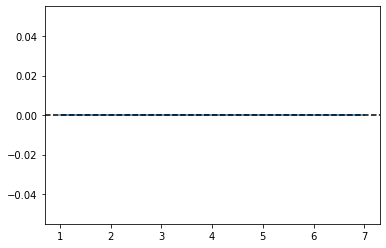

In [20]:
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

def Gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))
N = len(nights)
std = np.zeros(N)
mu = np.zeros(N)
A = np.zeros(N)

for i in range(N):
    x, y = np.loadtxt('ELT_VLT_14nights.txt', delimiter='\t', unpack=True)
    x = (phis) * 180 / np.pi
    y = L[i,:] * np.pi / 180
    coeff, _ = curve_fit(Gauss, x, y, p0=[1.0, 0.0, 5], bounds=([0, -2, 0], [100, 2, 100]), maxfev=3000)
    #mu[i] = coeff[1]
    #std[i] = coeff[2]
    #A[i] = coeff[0]
    print(i, coeff[2])


#plt.fill_between(nights, mu + 5*std, mu - 5*std, alpha=0.3)

plt.plot(to_plot, std)
plt.axhline(y=0, color='black', linestyle='--')
#plt.xlim(100, 365)
#plt.ylim(-5, 5)

In [132]:
np.savetxt('ELT_VLT_sigma_vs_time.txt', np.c_[to_plot, std], delimiter='\t')





In [3]:
t, s = np.loadtxt('CTA_VLT_sigma_vs_time.txt', delimiter='\t', unpack=True)
t1, s1 = np.loadtxt('CTA_sigma_vs_time.txt', delimiter='\t', unpack=True)
t2, s2 = np.loadtxt('ELT_VLT_sigma_vs_time.txt', delimiter='\t', unpack=True)

Text(0, 0.5, '$\\Delta \\phi$ [deg]')

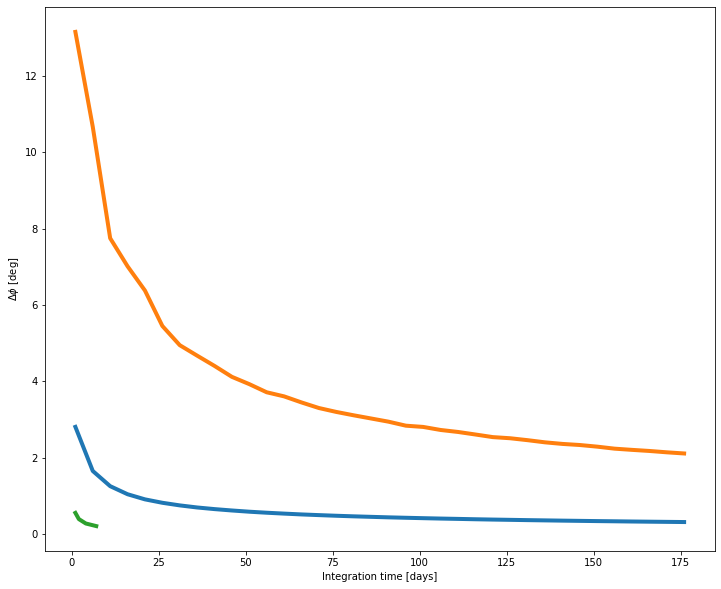

In [134]:
fig = plt.figure(figsize=(12,10))

plt.plot(t, s,  lw=4)
plt.plot(t1, s1,  lw=4)
plt.plot(t2, s2,  lw=4)
plt.xlabel('Integration time [days]')
plt.ylabel(r'$\Delta \phi$ [deg]')

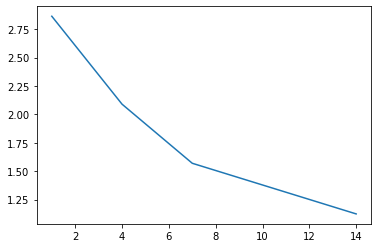

In [105]:
plt.plot(n, s)

In [49]:
print(std)

[ 5.05924631  3.41832813  2.66235001  2.29798104 -2.19932908  1.98484551
  1.84324897  1.65904405  1.71158022  1.52661382  1.40397884  1.42750481]


In [95]:
5000/128

39.0625

In [136]:
badboys = [0, 1, 2, 3]#,1,2,3,6,7,9]

13.451409516449333
9.573586169239489
7.372611542111135
2.0865699747953483


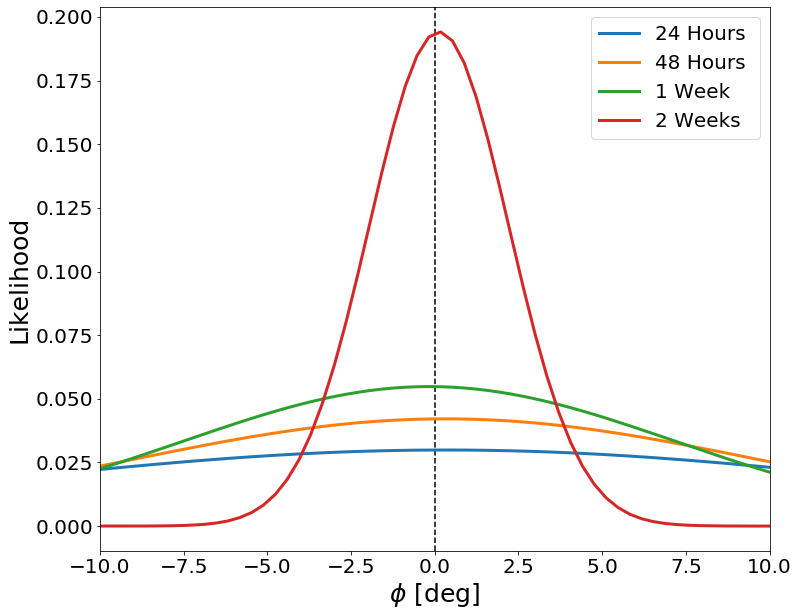

In [272]:
fig = plt.figure(figsize=(12,10))
plt.axvline(x=0, linestyle="--", c='k')

A = np.array(A)
shift = [0.01, 0.2, -0.01, 0]
labels = ['24 Hours', '48 Hours ', '1 Week', '2 Weeks']
for idx in badboys:
    x = np.linspace(-phi_range* 180 / np.pi, phi_range* 180 / np.pi, 256)
    y = A[idx]*np.exp(-(x-mu[idx]+shift[idx])**2/(2.*std[idx]**2))
    #x = np.array(phis * 180 / np.pi, dtype=np.float32)
    #y = np.array(L[idx,:] / 180 * np.pi, dtype=np.float32)
    #plt.plot(x,y, c='C{}'.format(idx))
    plt.plot(x, y, '-', c='C{}'.format(idx), label=labels[idx], lw=3)
    #np.savetxt("CTA_{}nights.txt".format(to_plot[idx]), np.c_[x, y], delimiter='\t')
    
    print(std[idx])
    
plt.legend(fontsize=20)
plt.xlim(-10, 10)
#plt.ylim(0, 4)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.xlabel('$\phi$ [deg]',fontsize=25)
plt.ylabel('Likelihood',fontsize=25)  
plt.show()

0.352941176470587
0.1764705882352935
0.04411764705882337
0.04411764705882337
0.04411764705882337
0.04411764705882337


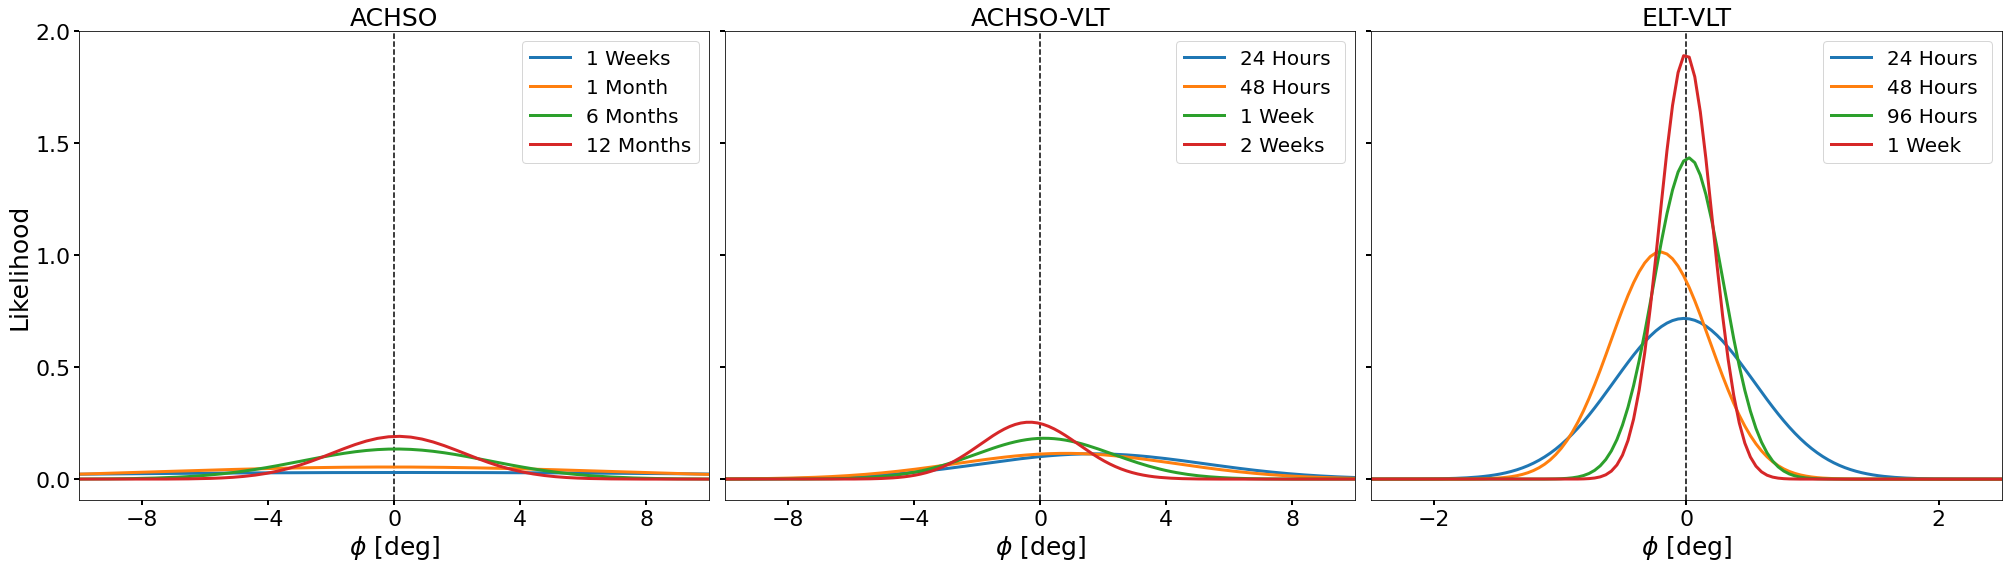

In [4]:
fig, ax = plt.subplots(1,3, figsize=(28,8), sharey=True)

ax[0].axvline(x=0, linestyle="--", c='k')
ax[1].axvline(x=0, linestyle="--", c='k')
ax[2].axvline(x=0, linestyle="--", c='k')

labels0 = ['1 Weeks', '1 Month ', '6 Months', '12 Months']
labels1 = ['24 Hours', '48 Hours ', '1 Week', '2 Weeks']
labels2 = ['24 Hours', '48 Hours ', '96 Hours', '1 Week']

x, y = np.loadtxt('CTA_7nights.txt', delimiter='\t', unpack=True)
dx = x[1]-x[0];norm = np.sum(y)*dx;y = y/norm;print(dx)
ax[0].plot(x, y, '-', label=labels0[0], lw=3)
x, y = np.loadtxt('CTA_30nights.txt', delimiter='\t', unpack=True)
dx = x[1]-x[0];norm = np.sum(y)*dx;y = y/norm
ax[0].plot(x, y, '-', label=labels0[1], lw=3)
x, y = np.loadtxt('CTA_180nights.txt', delimiter='\t', unpack=True)
dx = x[1]-x[0];norm = np.sum(y)*dx;y = y/norm
ax[0].plot(x, y, '-', label=labels0[2], lw=3)
x, y = np.loadtxt('CTA_360nights.txt', delimiter='\t', unpack=True)
dx = x[1]-x[0];norm = np.sum(y)*dx;y = y/norm
ax[0].plot(x, y, '-', label=labels0[3], lw=3)

x, y = np.loadtxt('CTA_VLT_1nights.txt', delimiter='\t', unpack=True)
dx = x[1]-x[0];norm = np.sum(y)*dx;y = y/norm;print(dx)
ax[1].plot(x, y, '-', label=labels1[0], lw=3)
x, y = np.loadtxt('CTA_VLT_2nights.txt', delimiter='\t', unpack=True)
dx = x[1]-x[0];norm = np.sum(y)*dx;y = y/norm
ax[1].plot(x, y, '-', label=labels1[1], lw=3)
x, y = np.loadtxt('CTA_VLT_7nights.txt', delimiter='\t', unpack=True)
dx = x[1]-x[0];norm = np.sum(y)*dx;y = y/norm
ax[1].plot(x, y, '-', label=labels1[2], lw=3)
x, y = np.loadtxt('CTA_VLT_14nights.txt', delimiter='\t', unpack=True)
dx = x[1]-x[0];norm = np.sum(y)*dx;y = y/norm
ax[1].plot(x, y, '-', label=labels1[3], lw=3)

x, y = np.loadtxt('ELT_VLT_1nights.txt', delimiter='\t', unpack=True)
dx = x[1]-x[0];norm = np.sum(y)*dx;y = y/norm;print(dx)
ax[2].plot(x, y, '-', label=labels2[0], lw=3)
x, y = np.loadtxt('ELT_VLT_2nights.txt', delimiter='\t', unpack=True)
dx = x[1]-x[0];norm = np.sum(y)*dx;y = y/norm;print(dx)
ax[2].plot(x, y, '-', label=labels2[1], lw=3)
x, y = np.loadtxt('ELT_VLT_4nights.txt', delimiter='\t', unpack=True)
dx = x[1]-x[0];norm = np.sum(y)*dx;y = y/norm;print(dx)
ax[2].plot(x, y, '-', label=labels2[2], lw=3)
x, y = np.loadtxt('ELT_VLT_7nights.txt', delimiter='\t', unpack=True)
dx = x[1]-x[0];norm = np.sum(y)*dx;y = y/norm;print(dx)
ax[2].plot(x, y, '-', label=labels2[3], lw=3)


ax[0].legend(fontsize=20)
ax[1].legend(fontsize=20)
ax[2].legend(fontsize=20)

ax[0].set_xlim(-10, 10)
ax[1].set_xlim(-10, 10)
ax[2].set_xlim(-2.5, 2.5)

plt.yticks(labelsize=22)

ax[0].set_yticks([0,0.5,1, 1.5, 2])
ax[0].set_xticks([-8,-4,0, 4, 8])

ax[1].set_yticks([0,0.5,1, 1.5, 2])
ax[1].set_xticks([-8,-4,0, 4, 8])

ax[2].set_yticks([0,0.5,1, 1.5, 2])
ax[2].set_xticks([-2,0, 2])
ax[0].set_ylabel('Likelihood',fontsize=25) 
ax[0].tick_params(axis='both', which='both', labelsize=22, length=5, width=2)
ax[1].tick_params(axis='both', which='major', labelsize=22, length=5, width=2)
ax[2].tick_params(axis='both', which='major', labelsize=22, length=5, width=2)

ax[0].set_title('ACHSO',fontsize=25)
ax[1].set_title('ACHSO-VLT',fontsize=25)
ax[2].set_title('ELT-VLT',fontsize=25)

ax[0].set_xlabel('$\phi$ [deg]',fontsize=25)
ax[1].set_xlabel('$\phi$ [deg]',fontsize=25)
ax[2].set_xlabel('$\phi$ [deg]',fontsize=25)
plt.tight_layout()
plt.savefig('all_likelihoods.pdf')

In [169]:
np.pi/4 / 256 * 180 / np.pi


0.17578125

In [16]:
ellipticities=[0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15]
N_e = len(ellipticities)

In [37]:
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
from matplotlib.lines import Line2D
# sympy allows symbolic calculations, so an arbitrary float precision.
# That's the only way I found to deal with the crazy numbers in the 
# likelihood function before normalization. Im pretty sure there exists
# way more elegant methods. Feel free to make it cleaner !!
import sympy as sp
N_phi    = 128
N_nights = 10
L = np.array([sp.zeros(N_phi, 1) for i in range(N_e)])

for i, e in enumerate(ellipticities):
    print(e)
    ls = II.LightSource(shape='ellipse', ellipticity=e)
    uv = II.UVplane(ls)
    cta = II.CTA(uv, bAddVLT=False, nGrid=128, nPerTraj=256)
    snr = cta.getSNRGrid()
    mask = snr > 0


    phi_range = np.pi/8
    phis = np.linspace(-phi_range, phi_range, N_phi)
    dphi = 2 * phi_range / N_phi
    signal = cta.getSignal(nNights = N_nights, phi_source = 0, bNoise=True)

    for k, phi in enumerate(phis):
        model = cta.getSignal(nNights = N_nights, phi_source = phi, bNoise=False)
        std = model[mask] / (snr[mask] * np.sqrt(N_nights))
        obs = signal[mask]
        exp = model[mask]
        chi2 =  (obs - exp)**2 / std**2
        p = sp.exp(-0.5*np.sum(chi2))
        L[i,k] = p
        
    norm = np.sum(L[i,:]) * dphi
    L[i,:] = L[i,:] / norm

0.01
Computing SNR grid:



Pairs (23-23): 100%|██████████| 28/28 [00:00<00:00, 46.98it/s]

Pairs (04-23):  42%|████▏     | 1145/2701 [00:26<00:36, 42.83it/s]


Pairs (04-23):  86%|████████▌ | 2315/2701 [00:53<00:08, 46.73it/s]


Pairs (04-23): 100%|██████████| 2701/2701 [01:03<00:00, 42.85it/s]

Pairs (04-04):   8%|▊         | 785/9730 [00:17<03:27, 43.14it/s]


Pairs (04-04):  20%|██        | 1955/9730 [00:44<03:03, 42.32it/s]


Pairs (04-04):  32%|███▏      | 3125/9730 [01:11<02:32, 43.34it/s]


Pairs (04-04):  44%|████▍     | 4295/9730 [01:39<02:08, 42.15it/s]


Pairs (04-04):  56%|█████▌    | 5465/9730 [02:06<01:33, 45.42it/s]


Pairs (04-04):  68%|██████▊   | 6635/9730 [02:33<01:10, 43.99it/s]


Pairs (04-04):  80%|████████  | 7805/9730 [03:00<00:44, 43.20it/s]


Pairs (04-04):  92%|█████████▏| 8972/9730 [03:28<00:18, 41.63it/s]


Pairs (04-04): 100%|██████████| 9730/9730 [03:45<00:00, 43.08it/s]

Pairs (12-23): 100%|██████████| 406/406 [00:09<00:00, 41.83it/s]

Pairs (12-04):   0%|          | 5/4465 [00:00<01:46, 41.97it/s]


Pairs (12-04):  13%|█▎        | 600/4465 [00:13<01:30, 42.63it/s]


Pairs (12-04):  40%|███▉      | 1775/4465 [00:40<00:58, 46.15it/s]


Pairs (12-04):  66%|██████▌   | 2945/4465 [01:07<00:32, 47.43it/s]


Pairs (12-04):  92%|█████████▏| 4115/4465 [01:33<00:07, 44.53it/s]


Pairs (12-04): 100%|██████████| 4465/4465 [01:40<00:00, 44.27it/s]

Pairs (12-12):  67%|██████▋   | 819/1225 [00:18<00:08, 46.69it/s]


Pairs (12-12): 100%|██████████| 1225/1225 [00:27<00:00, 43.93it/s]


0.03
Computing SNR grid:



Pairs (23-23): 100%|██████████| 28/28 [00:00<00:00, 46.52it/s]

Pairs (04-23):  42%|████▏     | 1145/2701 [00:25<00:34, 45.19it/s]


Pairs (04-23):  86%|████████▌ | 2315/2701 [00:51<00:09, 42.33it/s]


Pairs (04-23): 100%|██████████| 2701/2701 [00:59<00:00, 45.12it/s]

Pairs (04-04):   8%|▊         | 785/9730 [00:17<03:24, 43.76it/s]


Pairs (04-04):  20%|██        | 1955/9730 [00:44<02:51, 45.46it/s]


Pairs (04-04):  32%|███▏      | 3125/9730 [01:10<02:38, 41.75it/s]


Pairs (04-04):  44%|████▍     | 4295/9730 [01:37<02:07, 42.75it/s]


Pairs (04-04):  56%|█████▌    | 5465/9730 [02:05<01:39, 42.78it/s]


Pairs (04-04):  68%|██████▊   | 6634/9730 [02:32<01:10, 43.95it/s]


Pairs (04-04):  80%|████████  | 7804/9730 [03:00<00:44, 43.53it/s]


Pairs (04-04):  92%|█████████▏| 8974/9730 [03:27<00:17, 42.34it/s]


Pairs (04-04): 100%|██████████| 9730/9730 [03:45<00:00, 43.19it/s]

Pairs (12-23): 100%|██████████| 406/406 [00:09<00:00, 42.72it/s]

Pairs (12-04):   0%|          | 5/4465 [00:00<01:46, 41.74it/s]


Pairs (12-04):  13%|█▎        | 600/4465 [00:13<01:29, 43.08it/s]


Pairs (12-04):  40%|███▉      | 1775/4465 [00:40<01:02, 43.12it/s]


Pairs (12-04):  66%|██████▌   | 2945/4465 [01:07<00:33, 45.83it/s]


Pairs (12-04):  92%|█████████▏| 4115/4465 [01:33<00:07, 45.88it/s]


Pairs (12-04): 100%|██████████| 4465/4465 [01:41<00:00, 44.03it/s]

Pairs (12-12):  67%|██████▋   | 820/1225 [00:18<00:08, 45.42it/s]


Pairs (12-12): 100%|██████████| 1225/1225 [00:27<00:00, 44.43it/s]


0.05
Computing SNR grid:



Pairs (23-23): 100%|██████████| 28/28 [00:00<00:00, 46.69it/s]

Pairs (04-23):  42%|████▏     | 1145/2701 [00:26<00:36, 42.46it/s]


Pairs (04-23):  86%|████████▌ | 2315/2701 [00:52<00:08, 44.15it/s]


Pairs (04-23): 100%|██████████| 2701/2701 [01:01<00:00, 43.82it/s]

Pairs (04-04):   8%|▊         | 785/9730 [00:17<03:30, 42.48it/s]


Pairs (04-04):  20%|██        | 1955/9730 [00:43<02:44, 47.20it/s]


Pairs (04-04):  32%|███▏      | 3125/9730 [01:09<02:41, 40.95it/s]


Pairs (04-04):  44%|████▍     | 4295/9730 [01:36<02:10, 41.49it/s]


Pairs (04-04):  56%|█████▌    | 5465/9730 [02:03<01:33, 45.70it/s]


Pairs (04-04):  68%|██████▊   | 6635/9730 [02:29<01:09, 44.61it/s]


Pairs (04-04):  80%|████████  | 7805/9730 [02:55<00:44, 43.17it/s]


Pairs (04-04):  92%|█████████▏| 8975/9730 [03:22<00:17, 44.29it/s]


Pairs (04-04): 100%|██████████| 9730/9730 [03:39<00:00, 44.36it/s]

Pairs (12-23): 100%|██████████| 406/406 [00:08<00:00, 46.05it/s]

Pairs (12-04):   0%|          | 5/4465 [00:00<01:44, 42.79it/s]


Pairs (12-04):  13%|█▎        | 600/4465 [00:13<01:24, 45.95it/s]


Pairs (12-04):  40%|███▉      | 1775/4465 [00:39<01:04, 41.45it/s]


Pairs (12-04):  66%|██████▌   | 2943/4465 [01:07<00:34, 43.53it/s]


Pairs (12-04):  91%|█████████▏| 4078/4465 [01:34<00:09, 41.60it/s]


Pairs (12-04): 100%|██████████| 4465/4465 [01:44<00:00, 42.89it/s]

Pairs (12-12):  62%|██████▏   | 759/1225 [00:18<00:10, 42.37it/s]


Pairs (12-12): 100%|██████████| 1225/1225 [00:28<00:00, 42.25it/s]


0.07
Computing SNR grid:



Pairs (23-23): 100%|██████████| 28/28 [00:00<00:00, 43.89it/s]

Pairs (04-23):  42%|████▏     | 1145/2701 [00:27<00:36, 42.07it/s]


Pairs (04-23):  85%|████████▌ | 2308/2701 [00:54<00:08, 44.41it/s]


Pairs (04-23): 100%|██████████| 2701/2701 [01:03<00:00, 42.60it/s]

Pairs (04-04):   8%|▊         | 775/9730 [00:18<03:22, 44.12it/s]


Pairs (04-04):  20%|█▉        | 1938/9730 [00:45<02:59, 43.35it/s]


Pairs (04-04):  32%|███▏      | 3097/9730 [01:14<02:51, 38.67it/s]


Pairs (04-04):  44%|████▍     | 4265/9730 [01:41<01:57, 46.37it/s]


Pairs (04-04):  56%|█████▌    | 5435/9730 [02:08<01:34, 45.57it/s]


Pairs (04-04):  68%|██████▊   | 6605/9730 [02:34<01:07, 46.29it/s]


Pairs (04-04):  80%|███████▉  | 7775/9730 [03:00<00:44, 43.60it/s]


Pairs (04-04):  92%|█████████▏| 8943/9730 [03:28<00:18, 41.74it/s]


Pairs (04-04): 100%|██████████| 9730/9730 [03:47<00:00, 42.82it/s]

Pairs (12-23):  96%|█████████▌| 390/406 [00:08<00:00, 45.91it/s]


Pairs (12-23): 100%|██████████| 406/406 [00:09<00:00, 43.67it/s]

Pairs (12-04):  26%|██▌       | 1159/4465 [00:26<01:11, 46.56it/s]


Pairs (12-04):  52%|█████▏    | 2329/4465 [00:53<00:51, 41.25it/s]


Pairs (12-04):  78%|███████▊  | 3499/4465 [01:19<00:21, 44.86it/s]


Pairs (12-04): 100%|██████████| 4465/4465 [01:41<00:00, 43.87it/s]

Pairs (12-12):  16%|█▋        | 200/1225 [00:04<00:22, 46.37it/s]


Pairs (12-12): 100%|██████████| 1225/1225 [00:27<00:00, 44.50it/s]


0.09
Computing SNR grid:



Pairs (23-23): 100%|██████████| 28/28 [00:00<00:00, 46.83it/s]

Pairs (04-23):  42%|████▏     | 1143/2701 [00:27<00:38, 40.16it/s]


Pairs (04-23):  85%|████████▌ | 2303/2701 [00:55<00:09, 41.61it/s]


Pairs (04-23): 100%|██████████| 2701/2701 [01:04<00:00, 41.71it/s]

Pairs (04-04):   8%|▊         | 773/9730 [00:18<03:35, 41.53it/s]


Pairs (04-04):  20%|█▉        | 1941/9730 [00:44<03:03, 42.40it/s]


Pairs (04-04):  32%|███▏      | 3111/9730 [01:12<02:34, 42.82it/s]


Pairs (04-04):  44%|████▍     | 4280/9730 [01:39<02:07, 42.64it/s]


Pairs (04-04):  54%|█████▍    | 5296/9730 [02:07<01:50, 40.04it/s]


Pairs (04-04):  66%|██████▋   | 6463/9730 [02:35<01:17, 41.88it/s]


Pairs (04-04):  78%|███████▊  | 7633/9730 [03:03<00:52, 40.19it/s]


Pairs (04-04):  90%|█████████ | 8803/9730 [03:30<00:22, 41.30it/s]


Pairs (04-04): 100%|██████████| 9730/9730 [03:52<00:00, 41.88it/s]

Pairs (12-23):  56%|█████▌    | 228/406 [00:05<00:04, 40.89it/s]


Pairs (12-23): 100%|██████████| 406/406 [00:09<00:00, 42.87it/s]

Pairs (12-04):  22%|██▏       | 1001/4465 [00:23<01:19, 43.71it/s]


Pairs (12-04):  49%|████▊     | 2171/4465 [00:50<00:55, 41.36it/s]


Pairs (12-04):  75%|███████▍  | 3341/4465 [01:17<00:24, 45.43it/s]


Pairs (12-04): 100%|██████████| 4465/4465 [01:43<00:00, 43.18it/s]

Pairs (12-12):   3%|▎         | 40/1225 [00:00<00:27, 42.60it/s]


Pairs (12-12): 100%|█████████▉| 1220/1225 [00:28<00:00, 46.22it/s]


Pairs (12-12): 100%|██████████| 1225/1225 [00:28<00:00, 43.35it/s]


0.11
Computing SNR grid:



Pairs (23-23): 100%|██████████| 28/28 [00:00<00:00, 46.17it/s]

Pairs (04-23):  42%|████▏     | 1145/2701 [00:26<00:33, 45.82it/s]


Pairs (04-23):  86%|████████▌ | 2315/2701 [00:52<00:08, 43.15it/s]


Pairs (04-23): 100%|██████████| 2701/2701 [01:01<00:00, 43.80it/s]

Pairs (04-04):   8%|▊         | 784/9730 [00:17<03:23, 43.87it/s]


Pairs (04-04):  20%|█▉        | 1935/9730 [00:45<03:10, 41.00it/s]


Pairs (04-04):  32%|███▏      | 3089/9730 [01:13<02:26, 45.21it/s]


Pairs (04-04):  43%|████▎     | 4200/9730 [01:43<02:10, 42.36it/s]


Pairs (04-04):  55%|█████▌    | 5353/9730 [02:11<01:41, 43.10it/s]


Pairs (04-04):  67%|██████▋   | 6494/9730 [02:39<01:14, 43.17it/s]


Pairs (04-04):  79%|███████▊  | 7645/9730 [03:07<00:49, 42.06it/s]


Pairs (04-04):  91%|█████████ | 8815/9730 [03:34<00:21, 43.42it/s]


Pairs (04-04): 100%|██████████| 9730/9730 [03:56<00:00, 41.21it/s]

Pairs (12-23):  62%|██████▏   | 250/406 [00:06<00:03, 42.47it/s]


Pairs (12-23): 100%|██████████| 406/406 [00:09<00:00, 42.56it/s]

Pairs (12-04):  21%|██        | 926/4465 [00:24<01:34, 37.51it/s]


Pairs (12-04):  46%|████▋     | 2069/4465 [00:50<00:51, 46.26it/s]


Pairs (12-04):  72%|███████▏  | 3237/4465 [01:17<00:29, 41.44it/s]


Pairs (12-04):  99%|█████████▊| 4403/4465 [01:45<00:01, 39.46it/s]


Pairs (12-04): 100%|██████████| 4465/4465 [01:46<00:00, 41.80it/s]

Pairs (12-12):  90%|█████████ | 1104/1225 [00:26<00:02, 43.04it/s]


Pairs (12-12): 100%|██████████| 1225/1225 [00:29<00:00, 41.89it/s]


0.13
Computing SNR grid:



Pairs (23-23): 100%|██████████| 28/28 [00:00<00:00, 44.57it/s]

Pairs (04-23):  40%|███▉      | 1068/2701 [00:25<00:41, 39.77it/s]


Pairs (04-23):  79%|███████▉  | 2134/2701 [00:52<00:14, 39.31it/s]


Pairs (04-23): 100%|██████████| 2701/2701 [01:05<00:00, 40.95it/s]

Pairs (04-04):   6%|▌         | 549/9730 [00:13<03:46, 40.52it/s]


Pairs (04-04):  18%|█▊        | 1721/9730 [00:42<03:15, 40.99it/s]


Pairs (04-04):  30%|██▉       | 2879/9730 [01:10<02:50, 40.26it/s]


Pairs (04-04):  42%|████▏     | 4044/9730 [01:39<02:21, 40.16it/s]


Pairs (04-04):  53%|█████▎    | 5189/9730 [02:07<01:54, 39.70it/s]


Pairs (04-04):  65%|██████▌   | 6339/9730 [02:36<01:26, 39.22it/s]


Pairs (04-04):  77%|███████▋  | 7490/9730 [03:04<00:55, 40.42it/s]


Pairs (04-04):  89%|████████▉ | 8658/9730 [03:32<00:26, 40.39it/s]


Pairs (04-04): 100%|██████████| 9730/9730 [03:58<00:00, 40.87it/s]

Pairs (12-23):  23%|██▎       | 94/406 [00:02<00:07, 42.60it/s]


Pairs (12-23): 100%|██████████| 406/406 [00:09<00:00, 42.41it/s]

Pairs (12-04):  19%|█▉        | 870/4465 [00:20<01:24, 42.56it/s]


Pairs (12-04):  45%|████▌     | 2031/4465 [00:48<00:59, 40.62it/s]


Pairs (12-04):  72%|███████▏  | 3196/4465 [01:16<00:31, 40.69it/s]


Pairs (12-04):  97%|█████████▋| 4336/4465 [01:45<00:03, 41.79it/s]


Pairs (12-04): 100%|██████████| 4465/4465 [01:48<00:00, 41.01it/s]

Pairs (12-12):  82%|████████▏ | 1009/1225 [00:25<00:05, 40.50it/s]


Pairs (12-12): 100%|██████████| 1225/1225 [00:30<00:00, 39.74it/s]


0.15
Computing SNR grid:



Pairs (23-23): 100%|██████████| 28/28 [00:00<00:00, 42.50it/s]

Pairs (04-23):  41%|████      | 1099/2701 [00:27<00:35, 45.42it/s]


Pairs (04-23):  84%|████████▍ | 2269/2701 [00:54<00:10, 42.92it/s]


Pairs (04-23): 100%|██████████| 2701/2701 [01:04<00:00, 41.79it/s]

Pairs (04-04):   8%|▊         | 740/9730 [00:17<03:35, 41.77it/s]


Pairs (04-04):  19%|█▉        | 1892/9730 [00:45<03:06, 42.05it/s]


Pairs (04-04):  31%|███▏      | 3047/9730 [01:13<02:38, 42.14it/s]


Pairs (04-04):  43%|████▎     | 4183/9730 [01:41<02:20, 39.54it/s]


Pairs (04-04):  54%|█████▍    | 5249/9730 [02:08<01:53, 39.49it/s]


Pairs (04-04):  65%|██████▍   | 6307/9730 [02:34<01:25, 40.07it/s]


Pairs (04-04):  77%|███████▋  | 7461/9730 [03:03<00:56, 40.03it/s]


Pairs (04-04):  89%|████████▊ | 8613/9730 [03:31<00:27, 39.90it/s]


Pairs (04-04): 100%|█████████▉| 9721/9730 [03:59<00:00, 39.77it/s]


Pairs (04-04): 100%|██████████| 9730/9730 [03:59<00:00, 40.58it/s]

Pairs (12-23): 100%|██████████| 406/406 [00:10<00:00, 39.55it/s]

Pairs (12-04):  15%|█▌        | 682/4465 [00:17<01:34, 40.14it/s]


Pairs (12-04):  41%|████      | 1816/4465 [00:45<01:04, 41.34it/s]


Pairs (12-04):  65%|██████▌   | 2906/4465 [01:12<00:39, 39.84it/s]


Pairs (12-04):  88%|████████▊ | 3950/4465 [01:38<00:12, 41.88it/s]


Pairs (12-04): 100%|██████████| 4465/4465 [01:50<00:00, 40.27it/s]

Pairs (12-12):  50%|█████     | 618/1225 [00:15<00:14, 40.92it/s]


Pairs (12-12): 100%|██████████| 1225/1225 [00:30<00:00, 40.32it/s]


0.01 6.143306267991326
0.03 1.8340627651386898
0.05 1.0714280997327394
0.07 0.7800688301627251
0.09 0.6087489283809292
0.11 0.49465508616577375
0.13 0.424485422742822
0.15 0.36957963513696823


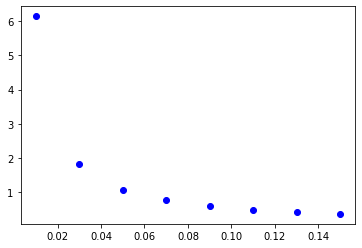

In [36]:
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

def Gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

N = N_e
std = np.zeros(N)
mu = np.zeros(N)
A = np.zeros(N)

for i in range(N):
    x = np.array(phis * 180 / np.pi, dtype=np.float32)
    y = np.array(L[i,:] / 180 * np.pi, dtype=np.float32)
    
    coeff, _ = curve_fit(Gauss, x, y, p0=[1.0, 0.0, 1.0], bounds=([0, -20, 0], [np.inf, 20, np.inf]), maxfev=30000)
    mu[i] = coeff[1]
    std[i] = coeff[2]
    A[i] = coeff[0]
    print(ellipticities[i], std[i])

#plt.fill_between(nights, mu + 5*std, mu - 5*std, alpha=0.3)

plt.plot(ellipticities, std,'bo')
#plt.xlim(100, 365)
#plt.ylim(-5, 5)

0.01 38.834764773654356
0.03 12.893669966761935
0.05 6.669387693187137
0.07 5.032151090404644
0.09 3.9693489010761476
0.11 3.2404513582317156
0.13 2.703843060744818
0.15 2.3010053674781585


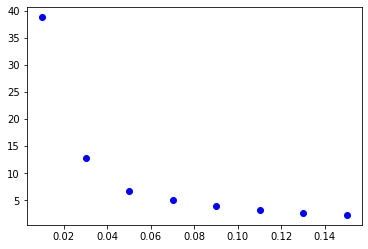

In [38]:
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

def Gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))
N = N_e
std = np.zeros(N)
mu = np.zeros(N)
A = np.zeros(N)

for i in range(N):
    x = np.array(phis * 180 / np.pi, dtype=np.float32)
    y = np.array(L[i,:] / 180 * np.pi, dtype=np.float32)
    
    coeff, _ = curve_fit(Gauss, x, y, p0=[1.0, 0.0, 1.0], bounds=([0, -20, 0], [np.inf, 20, np.inf]), maxfev=30000)
    mu[i] = coeff[1]
    std[i] = coeff[2]
    A[i] = coeff[0]
    print(ellipticities[i], std[i])

#plt.fill_between(nights, mu + 5*std, mu - 5*std, alpha=0.3)

plt.plot(ellipticities, std,'bo')
#plt.xlim(100, 365)
#plt.ylim(-5, 5)

In [30]:
L.shape
phis.shape

(128,)